<a href="https://colab.research.google.com/github/ikukang/MLwithPython/blob/master/5_3_convnet_pretrained_convnet_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [0]:
import os 
import shutil

base_dir = '/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small'
base_root_dir = '/gdrive/My Drive/Colab Notebooks/datasets/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [3]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

# 사전 훈련된 컨브넷 사용하기

## 특성 추출

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

### 방법1) 특성추출 후 FC만 학습


VGG16 모델은 케라스에 패키지로 포함되어 있습니다. `keras.applications` 모듈에서 임포트할 수 있습니다. `keras.applications` 모듈에서 사용 가능한 이미지 분류 모델은 다음과 같습니다(모두 ImageNet 데이터셋에서 훈련):

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

VGG16 모델

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

VGG16 함수에 세 개의 매개변수:

* `weights`는 모델을 초기화할 가중치 체크포인트를 지정
* `include_top`은 네트워크의 최상위 완전 연결 분류기를 포함할지 안할지를 지정합니다. 기본값은 ImageNet의 1,000개의 클래스에 대응되는 완전 연결 분류기를 포함합니다. 별도의 (강아지와 고양이 두 개의 클래스를 구분하는) 완전 연결 층을 추가하려고 하므로 이를 포함시키지 않습니다.
* `input_shape`은 네트워크에 주입할 이미지 텐서의 크기입니다. 이 매개변수는 선택사항입니다. 이 값을 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리할 수 있습니다.

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

#base_dir = './datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

dropout적용

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 405us/step - loss: 0.5896 - acc: 0.6905 - val_loss: 0.4241 - val_acc: 0.8460
Epoch 2/30
2000/2000 [==============================] - 1s 292us/step - loss: 0.4272 - acc: 0.8105 - val_loss: 0.3527 - val_acc: 0.8600
Epoch 3/30
2000/2000 [==============================] - 1s 307us/step - loss: 0.3667 - acc: 0.8315 - val_loss: 0.3222 - val_acc: 0.8700
Epoch 4/30
2000/2000 [==============================] - 1s 301us/step - loss: 0.3112 - acc: 0.8705 - val_loss: 0.2972 - val_acc: 0.8840
Epoch 5/30
2000/2000 [==============================] - 1s 327us/step - loss: 0.2883 - acc: 0.8835 - val_loss: 0.2820 - val_acc: 0.8880
Epoch 6/30
2000/2000 [==============================] - 1s

# Loss & Accuracy

In [0]:
import matplotlib.pyplot as plt

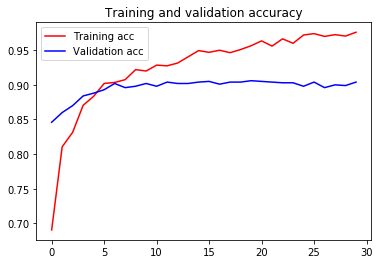

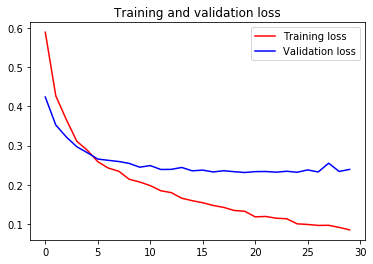

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

약 90%의 검증 정확도에 도달했습니다. 하지만 이 그래프는 많은 비율로 드롭아웃을 사용했음에도 불구하고 훈련이 시작하면서 거의 바로 과대적합되고 있다는 것을 보여줍니다. 작은 이미지 데이터셋에서는 과대적합을 막기 위해 필수적인 데이터 증식을 사용하지 않았기 때문입니다.

### 방법2 
-Freezing Conv + FC + Data Augmentation

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


여기서 볼 수 있듯이 VGG16의 합성곱 기반층은 14,714,688개의 매우 많은 파라미터를 가지고 있습니다. 합성곱 기반층 위에 추가한 분류기는 2백만 개의 파라미터를 가집니다.

모델을 컴파일하고 훈련하기 전에 합성곱 기반층을 동결하는 것이 아주 중요합니다. 하나 이상의 층을 동결한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻입니다. 이렇게 하지 않으면 합성곱 기반층에 의해 사전에 학습된 표현이 훈련하는 동안 수정될 것입니다. 맨 위의 `Dense` 층은 랜덤하게 초기화되었기 때문에 매우 큰 가중치 업데이트 값이 네트워크에 전파될 것입니다. 이는 사전에 학습된 표현을 크게 훼손하게 됩니다.

케라스에서는 `trainable` 속성을 `False`로 설정하여 네트워크를 동결할 수 있습니다:

In [13]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [0]:
conv_base.trainable = False

In [15]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


데이터 증식을 사용하여 모델학습

In [16]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안됨
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 21s - loss: 0.5558 - acc: 0.7250 - val_loss: 0.4184 - val_acc: 0.8420
Epoch 2/30
 - 20s - loss: 0.4114 - acc: 0.8365 - val_loss: 0.3390 - val_acc: 0.8650
Epoch 3/30
 - 19s - loss: 0.3678 - acc: 0.8390 - val_loss: 0.3132 - val_acc: 0.8700
Epoch 4/30
 - 19s - loss: 0.3253 - acc: 0.8660 - val_loss: 0.2832 - val_acc: 0.8890
Epoch 5/30
 - 20s - loss: 0.3101 - acc: 0.8640 - val_loss: 0.2715 - val_acc: 0.8900
Epoch 6/30
 - 20s - loss: 0.2865 - acc: 0.8820 - val_loss: 0.2683 - val_acc: 0.8900
Epoch 7/30
 - 19s - loss: 0.2776 - acc: 0.8900 - val_loss: 0.2793 - val_acc: 0.8820
Epoch 8/30
 - 19s - loss: 0.2654 - acc: 0.8950 - val_loss: 0.2500 - val_acc: 0.8990
Epoch 9/30
 - 20s - loss: 0.2698 - acc: 0.8915 - val_loss: 0.2494 - val_acc: 0.8960
Epoch 10/30
 - 19s - loss: 0.2485 - acc: 0.8970 - val_loss: 0.2470 - val_acc: 0.8990
Epoch 11/30
 - 20s - loss: 0.2549 - acc: 0.8995 - val_loss: 0.2648 - val_ac

In [0]:
model.save(os.path.join(base_root_dir, 'cats_and_dogs_small_3.h5'))
#model.save('cats_and_dogs_small_3.h5')

# Accuracy & Loss

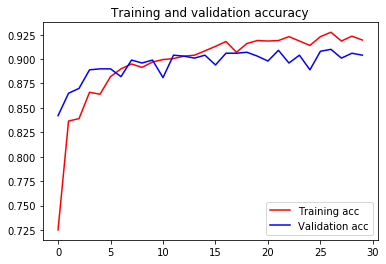

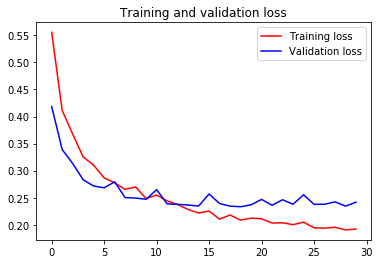

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 미세 조정(Fine tunning)

모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정입니다. 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것입니다. 주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라고 부릅니다.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [19]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

마지막 세 개의 합성곱 층을 미세 조정하겠습니다. 즉, `block4_pool`까지 모든 층은 동결되고 `block5_conv1`, `block5_conv2`, `block5_conv3` 층은 학습 대상이 됩니다.

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### 미세조정시작
학습률을 낮춘 RMSProp 옵티마이저를 사용합니다. 학습률을 낮추는 이유는 미세 조정하는 세 개의 층에서 학습된 표현을 조금씩 수정하기 위해서입니다. 변경량이 너무 크면 학습된 표현에 나쁜 영향을 끼칠 수 있습니다.

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 22s 222ms/step - loss: 0.1913 - acc: 0.9210 - val_loss: 0.2151 - val_acc: 0.9120
Epoch 2/100
100/100 [==============================] - 20s 200ms/step - loss: 0.1705 - acc: 0.9250 - val_loss: 0.2077 - val_acc: 0.9180
Epoch 3/100
100/100 [==============================] - 20s 195ms/step - loss: 0.1385 - acc: 0.9455 - val_loss: 0.2173 - val_acc: 0.9260
Epoch 4/100
100/100 [==============================] - 20s 198ms/step - loss: 0.1235 - acc: 0.9465 - val_loss: 0.2096 - val_acc: 0.9280
Epoch 5/100
100/100 [==============================] - 20s 198ms/step - loss: 0.0989 - acc: 0.9640 - val_loss: 0.2244 - val_acc: 0.9190
Epoch 6/100
100/100 [==============================] - 20s 198ms/step - loss: 0.0956 - acc: 0.9635 - val_loss: 0.2101 - val_acc: 0.9210
Epoch 7/100
100/100 [==============================] - 20s 197ms/step - loss: 0.0768 - acc: 0.9720 - val_loss: 0.2254 - val_acc: 0.9260
Epoch 8/100
100/100 [===========================

In [0]:
model.save(os.path.join(base_root_dir, 'cats_and_dogs_small_4.h5'))
#model.save('cats_and_dogs_small_4.h5')

### Accuracy & Loss

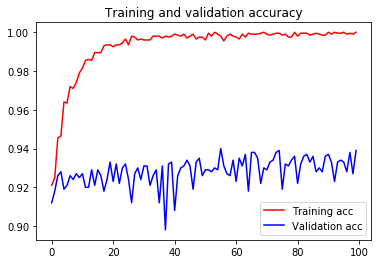

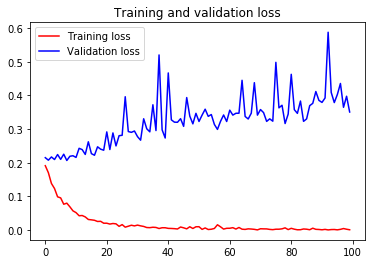

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

그래프가 불규칙하게 보입니다. 그래프를 보기 쉽게하기 위해 지수 이동 평균으로 정확도와 손실 값을 부드럽게 표현할 수 있습니다. 다음은 지수 이동 평균을 구하기 위한 간단한 함수입니다:

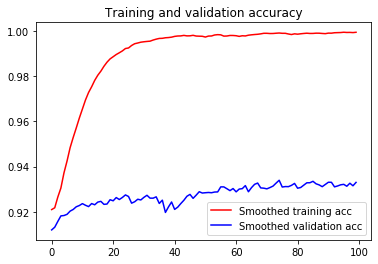

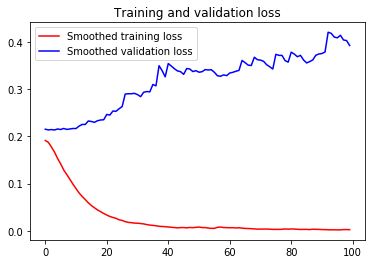

In [26]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


### 테스트 데이터에서 모델을 평가

In [25]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9349999928474426


92%의 테스트 정확도를 얻을 것입니다. 훈련 데이터의 일부분(약 10% - 2,000개의 샘플)만을 사용해서 이런 결과를 달성했습니다. 